Objective: Find which best features and their values that will result in a bike purchase.

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
import warnings
warnings.filterwarnings('ignore')

Loading data from file

In [160]:
path = 'bike_buyers.csv'
df = pd.read_csv(path, index_col=[0])
original_len = len(df)
original_len

1000

Collecting columns names (helpful in iteration)

In [161]:
column_label = df.columns.values.tolist()
column_label

['Marital Status',
 'Gender',
 'Income',
 'Children',
 'Education',
 'Occupation',
 'Home Owner',
 'Cars',
 'Commute Distance',
 'Region',
 'Age',
 'Purchased Bike']

Data clean-up <br>
Because we have a fairly large dataset we remove the NaN values instead of trying to fill them

In [162]:
for i in column_label:
    df = df[df[i].notna()]
print(f'Removed {original_len-len(df)} rows')
df.head()

Removed 48 rows


,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
ID,,,,,,,,,,,,
12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
13507,Married,Female,10000.0,2.0,Partial College,Manual,Yes,0.0,1-2 Miles,Europe,50.0,No


Feature coding

In [163]:
replace = {}
for i in column_label:
    if df[i].dtypes == 'object':
        replace[i] = list(df[i].unique()),list(np.arange(len(list(df[i].unique()))))
replace

{'Marital Status': (['Married', 'Single'], [0, 1]),
 'Gender': (['Female', 'Male'], [0, 1]),
 'Education': (['Bachelors',
   'Partial College',
   'High School',
   'Partial High School',
   'Graduate Degree'],
  [0, 1, 2, 3, 4]),
 'Occupation': (['Skilled Manual',
   'Clerical',
   'Professional',
   'Manual',
   'Management'],
  [0, 1, 2, 3, 4]),
 'Home Owner': (['Yes', 'No'], [0, 1]),
 'Commute Distance': (['0-1 Miles',
   '2-5 Miles',
   '1-2 Miles',
   '10+ Miles',
   '5-10 Miles'],
  [0, 1, 2, 3, 4]),
 'Region': (['Europe', 'Pacific', 'North America'], [0, 1, 2]),
 'Purchased Bike': (['No', 'Yes'], [0, 1])}

In [164]:
for i in list(replace.keys()):
    df[i] = df[i].replace(to_replace=replace[i][0],value=replace[i][1])
df.head(5)

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
ID,,,,,,,,,,,,
12496,0,0,40000.0,1.0,0,0,0,0.0,0,0,42.0,0
24107,0,1,30000.0,3.0,1,1,0,1.0,0,0,43.0,0
14177,0,1,80000.0,5.0,1,2,1,2.0,1,0,60.0,0
25597,1,1,30000.0,0.0,0,1,1,0.0,0,0,36.0,1
13507,0,0,10000.0,2.0,1,3,0,0.0,2,0,50.0,0


Feature selection<br>
We use 3 different methods of evaluating which features matter the most for our objective.
1. Corelation between columns and **Purchaseed Bike**
2. Statistical test (using chi^2)
3. Using a sklearn classifier

In [165]:
for i in column_label:
    print(f"{i}: {df[i].corr(df['Purchased Bike'])}")

Marital Status: 0.10604321785653367
Gender: -0.018659599707696223
Income: 0.04897545487068181
Children: -0.11754544754847646
Education: -0.03415356360224918
Occupation: -0.0223576550411056
Home Owner: 0.03305232988299371
Cars: -0.20517576980731234
Commute Distance: -0.1644201594379041
Region: -0.05714589930513447
Age: -0.1107985074521318
Purchased Bike: 1.0


<AxesSubplot:>

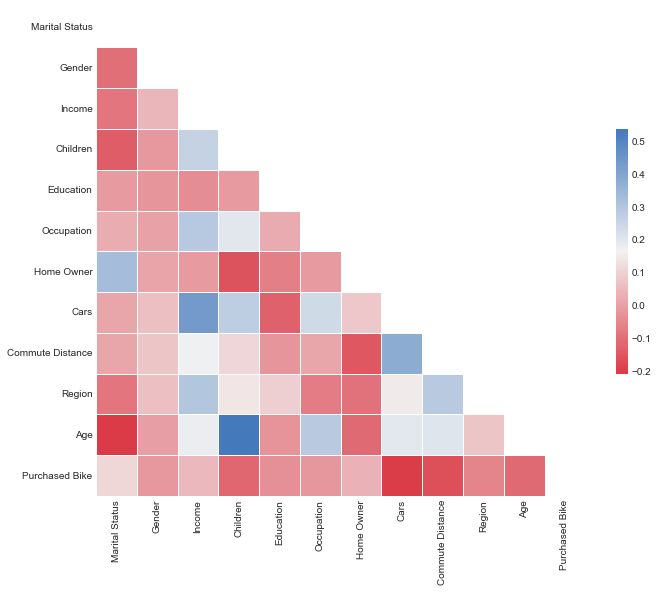

In [166]:
correlation = df.corr()
mask = np.triu(np.ones_like(correlation, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [167]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df[column_label[:-1]]
Y = df[column_label[-1]]

In [168]:
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featureScores.nlargest(5,'Score')

,Features,Score
2,Income,38822.430283
8,Commute Distance,36.975031
10,Age,34.452949
7,Cars,34.074327
3,Children,18.177295


[0.04176213 0.05807188 0.12983943 0.10758744 0.07525477 0.06512005
 0.04153175 0.09491034 0.1068891  0.05786791 0.2211652 ]


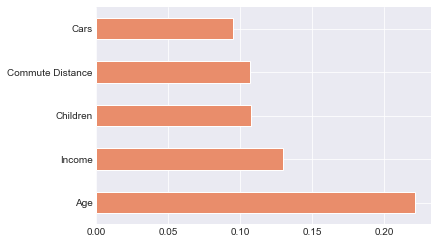

In [169]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_)
plt.style.use('seaborn-darkgrid')
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

We can observe that:
1. Corelation is very weak so it gives us not a meaningful answer.
2. Top 5 results in statistics based evalutaion and sklearn classifier are the same although the results are in the different order.

As a result we will focus on these features:
- Cars,
- Children,
- Income,
- Commute distance,
- Age,

Evaluating the quality of models

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [171]:
X = df[featureScores.nlargest(5,'Score')['Features'].to_list()]
Y = df['Purchased Bike']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5,random_state=1)

In [172]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

LR: 0.598537 (0.060454)
LDA: 0.590204 (0.055973)
KNN: 0.592154 (0.077076)
CART: 0.611436 (0.050621)
NB: 0.571277 (0.080279)
SVM: 0.594193 (0.053185)


Text(0.5, 1.0, 'Algorithm Comparison')

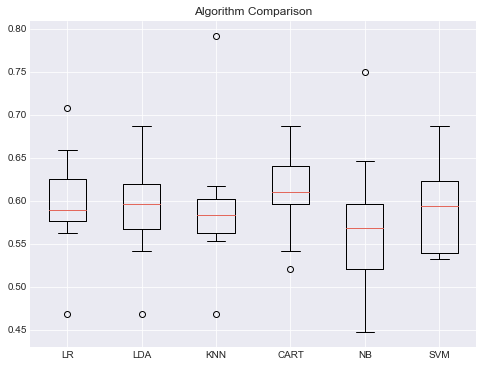

In [173]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.figure(figsize=(8,6))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')

Based on the results we choose to go with **Decision Tree Classifier**

Building a **CART** model

In [174]:
import pydotplus

In [175]:
selected_features = featureScores.nlargest(5,'Score')['Features'].to_list()
selected_features

['Income', 'Commute Distance', 'Age', 'Cars', 'Children']

In [176]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, Y_train)
data = tree.export_graphviz(dtree, out_file=None, feature_names=selected_features)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('decisiontree.png')
print('Decision Tree created')

Decision Tree created


Testing model accuracy

In [177]:
test_len = len(X_test)
passed = 0
for i in range(test_len):
    y_pred = dtree.predict([X_test.iloc[i].values.tolist()])[0]
    if y_pred == Y_test.iloc[i]:
        passed += 1
print(f'Accuracy of model = {passed/test_len}')

Accuracy of model = 0.6071428571428571


Finding our target clients:
1. Finding min/max values of dataset.
2. Finding matching clients from test dataset.
3. Grouping data by type.
4. Calculating median , average and most common values.
5. Presenting result.

In [178]:
prep_data = []
for i in selected_features:
    temp = X_test[i].values.tolist()
    prep_data.append([np.min(temp),np.max(temp)])
prep_data

[[10000.0, 170000.0], [0, 4], [25.0, 73.0], [0.0, 4.0], [0.0, 5.0]]

In [179]:
res = []
for i in range(len(X_test)):
    temp = X.iloc[i].values.tolist()
    ans = dtree.predict([temp])
    if ans[0] == 1:
        res.append(temp)
len(res)

254

In [180]:
result_values = {}
for i in range(len(res[0])):
    column = selected_features[i]
    result_values[column] = []
    for j in range(len(res)):
        result_values[column].append(res[j][i])


In [181]:
res_df_data = [[],[],[]]
for i in selected_features:
    Med = np.median(result_values[i])
    Max = max(set(result_values[i]), key = result_values[i].count)
    Avg = np.average(result_values[i])
    res_df_data[0].append(Med)
    res_df_data[1].append(Max)
    res_df_data[2].append(int(Avg))

In [182]:
res_df = pd.DataFrame(res_df_data,index = ['Median','Most Common','Average'],columns= selected_features)
i = 'Commute Distance'
res_df[i] = res_df[i].replace(to_replace=replace[i][1],value=replace[i][0])
res_df

,Income,Commute Distance,Age,Cars,Children
Median,40000.0,0-1 Miles,40.5,1.0,2.0
Most Common,40000.0,0-1 Miles,36.0,1.0,0.0
Average,54212.0,2-5 Miles,43.0,1.0,1.0


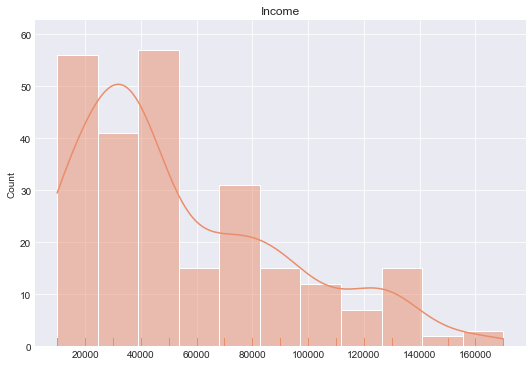

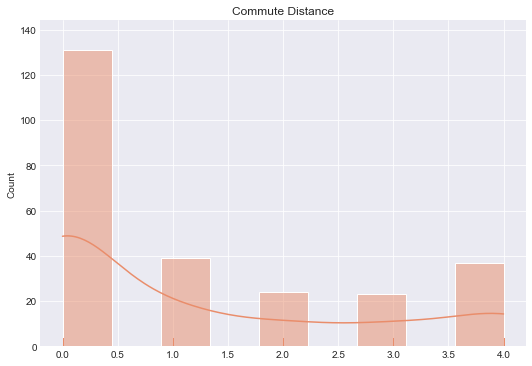

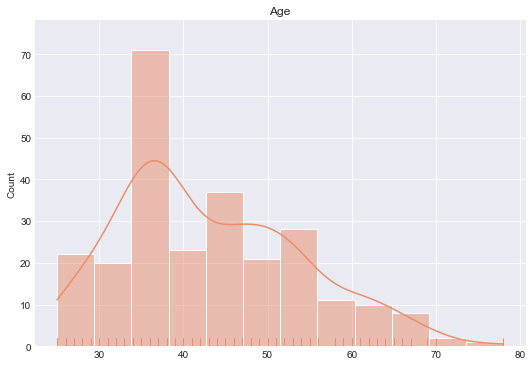

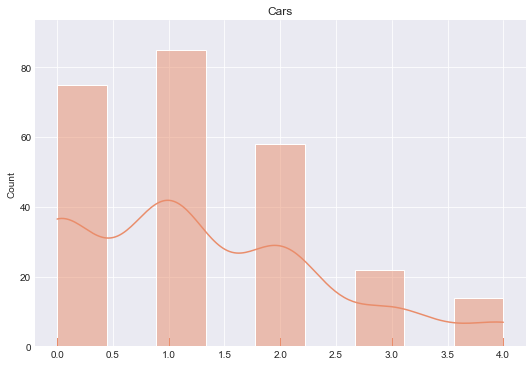

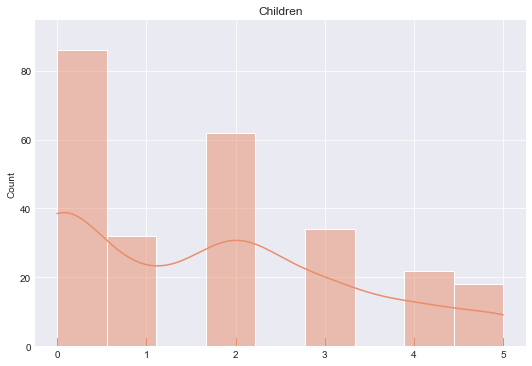

In [183]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':3})
for i in selected_features:
    data = result_values[i]
    sns.set_palette(palette='flare')
    sns.displot(data=data, label="Compact", kde=True,rug=True,height=5,aspect=1.5)
    plt.title(i)
    plt.show()